Example of post selection issue.

In [1]:
# set up Python
import logging

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from wvu.util import plot_roc, threshold_plot
from plotnine import *
from modeling_fns import (
    powerset,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
d = pd.read_csv("d_large.csv")
for c in ['x1', 'x2']:
    d[c] = d[c] + rng.normal(size=d.shape[0], scale=0.1)

d.head(10)

,x1,x2,y,presentation_group,row_id,sort_order,sampled_positive
0,1.102886,0.183668,1,1,1,-0.393781,False
1,0.164192,1.074680,1,1,2,-0.708220,True
2,0.114672,0.991857,1,1,3,-0.708220,False
3,0.902682,-0.187041,0,1,4,-0.393781,False
4,-0.139280,-0.052501,0,1,5,-0.364389,False
5,0.006720,0.839135,1,2,6,-0.708220,True
6,1.086135,1.035235,0,2,7,-0.733347,False
7,0.050919,1.065042,1,2,8,-0.708220,False
8,0.181029,0.005573,0,2,9,-0.364389,False
9,0.075084,0.152053,0,2,10,-0.364389,False


In [4]:
d.shape

(1000000, 7)

In [5]:
d_sampled = d.reset_index(drop=True, inplace=False)   # copy
d_sampled.loc[d_sampled['sampled_positive'] == False, 'y'] = 0
# d_sampled = d.loc[(d['sampled_positive'] == True) | (d['y'] == 0), :].reset_index(drop=True, inplace=False) 

Simple model on all selections.

In [6]:
model_all = LogisticRegression()
model_all.fit(d.loc[:, ['x1', 'x2']], d['y'])
d['logistic_all_predict'] = model_all.predict_proba(d.loc[:, ['x1', 'x2']])[:, 1]
(model_all.intercept_[0], model_all.coef_[0])

(-0.5164215649414858, array([0.09336111, 1.3728617 ]))

In [7]:
model_sampled = LogisticRegression()
model_sampled.fit(d_sampled.loc[:, ['x1', 'x2']], d_sampled['y'])
d['logistic_sample_predict'] = model_sampled.predict_proba(d.loc[:, ['x1', 'x2']])[:, 1]
(model_sampled.intercept_[0], model_sampled.coef_[0])

(-1.9764832273897193, array([-1.19022845,  1.99967027]))

In [8]:
d.head()

,x1,x2,y,presentation_group,row_id,sort_order,sampled_positive,logistic_all_predict,logistic_sample_predict
0,1.102886,0.183668,1,1,1,-0.393781,False,0.459761,0.051082
1,0.164192,1.074680,1,1,2,-0.708220,True,0.725975,0.494274
2,0.114672,0.991857,1,1,3,-0.708220,False,0.701817,0.467650
3,0.902682,-0.187041,0,1,4,-0.393781,False,0.334272,0.031526
4,-0.139280,-0.052501,0,1,5,-0.364389,False,0.354000,0.128343


<Figure size 640x480 with 0 Axes>

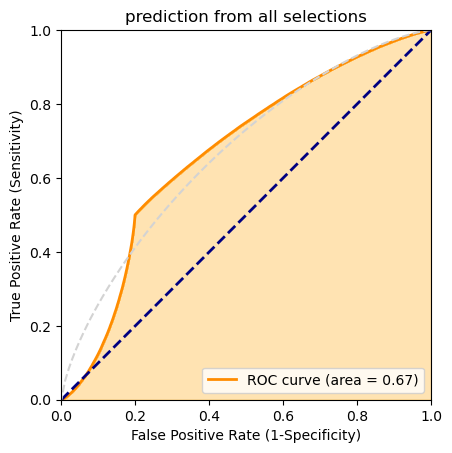

0.6690079839011869

In [9]:
plot_roc(
    prediction=d["logistic_all_predict"],
    istrue=d["y"],
    ideal_line_color="lightgrey",
    title="prediction from all selections",
)

<Figure size 640x480 with 0 Axes>

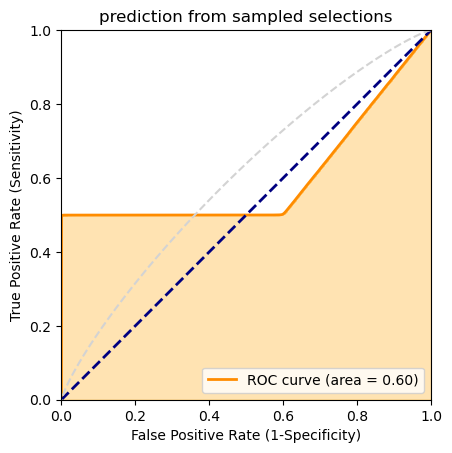

0.5998489035500676

In [10]:
plot_roc(
    prediction=d["logistic_sample_predict"],
    istrue=d["y"],
    ideal_line_color="lightgrey",
    title="prediction from sampled selections",
)